# SEMESTER PROJECT: USE YOUR BODY TO CONTROL A ROBOT - STUDY OF ROBOT MORPHOLOGY - ROVER

# Import 

In [30]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quaternion as quat
import quaternion_operations as quat_op

import HRI_mapping_add
import utils
#import helpers
import importlib
#importlib.reload(helpers)
#from helpers import compute_ea_df
import CalibrationDataset

import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from sklearn.cross_decomposition import CCA
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

settings = HRI_mapping_add.HRI_mapping_settings()
settings.used_body_parts=np.arange(1, 14)
settings.pll_mode = 'variance'

# Rover - import data

In [31]:
df1 = pd.read_csv('rover_subject1_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_11_07_16AM.txt')
df2 = pd.read_csv('rover_subject2_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_12_31_05PM.txt')
df3 = pd.read_csv('rover_subject3_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_01_21_24PM.txt')
df4 = pd.read_csv('rover_subject4_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_02_10_26PM.txt')
df5 = pd.read_csv('rover_subject5_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_02_19_29PM.txt')
df6 = pd.read_csv('rover_subject6_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_02_40_41PM.txt')
df7 = pd.read_csv('rover_subject7_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_03_53_42PM.txt')
df8 = pd.read_csv('rover_subject8_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_04_43_36PM.txt')
df9 = pd.read_csv('rover_subject9_motive_mixed_period_7_amplitude_50_inst_9_2019_May_15_05_10_10PM.txt')
df10 = pd.read_csv('rover_subject10_motive_mixed_period_7_amplitude_50_inst_9_2019_May_20_01_42_36PM.txt')
df11 = pd.read_csv('rover_subject11_motive_mixed_period_7_amplitude_50_inst_9_2019_May_20_02_31_11PM.txt')
df12 = pd.read_csv('rover_subject12_motive_mixed_period_7_amplitude_50_inst_9_2019_May_20_02_54_23PM.txt')
df13 = pd.read_csv('rover_subject13_motive_mixed_period_7_amplitude_50_inst_9_2019_May_24_03_34_03PM.txt')
df14 = pd.read_csv('rover_subject14_motive_mixed_period_7_amplitude_50_inst_9_2019_May_24_03_48_49PM.txt')
df15 = pd.read_csv('rover_subject15_motive_mixed_period_7_amplitude_50_inst_9_2019_May_24_06_08_55PM.txt')

In [32]:
def remove_initial_bias_quaterions(limb, dataframe):

    global PI

    dataframe_out = pd.DataFrame.copy(dataframe)

    absolute = []
    relative = []

    str_abs_w = 'quat_w_' + str(limb)

    str_abs_x = 'quat_x_' + str(limb)

    str_abs_y = 'quat_y_' + str(limb)

    str_abs_z = 'quat_z_' + str(limb)

    """if DEBUG :
        plt.figure()
        plt.plot(dataframe['roll_' + str(limb)].values, label="old")
    """

    reference = np.quaternion(dataframe[str_abs_w].values[0], dataframe[str_abs_x].values[0], dataframe[str_abs_y].values[0], dataframe[str_abs_z].values[0])

    for i in range(0, dataframe.shape[0]):

        absolute.append(np.quaternion(dataframe[str_abs_w].values[i], dataframe[str_abs_x].values[i], dataframe[str_abs_y].values[i], dataframe[str_abs_z].values[i]))

        relative.append(absolute[-1]/reference)

        dataframe_out[str_abs_w].values[i] = relative[-1].w
        dataframe_out[str_abs_x].values[i] = relative[-1].x
        dataframe_out[str_abs_y].values[i] = relative[-1].y
        dataframe_out[str_abs_z].values[i] = relative[-1].z

    """if DEBUG :
        plt.plot(dataframe_out['roll_' + str(limb)].values, label="new")
        plt.grid()
        plt.legend()
        plt.title('angle ' + str(limb))
    """
    return dataframe_out

for i in range(15):
    df_in = eval('df'+str(i+1)) 
    df_out = remove_initial_bias_quaterions(settings.used_body_parts[0], df_in)
    for i in settings.used_body_parts[1:]:
        df_out = remove_initial_bias_quaterions(i, df_out)
    local_namespace = locals()
    local_namespace['df'+str(i+1)] = df_out
    


In [33]:
def relativize_angles(angles_to_correct, with_respect_to, dataframe, DEBUG = 0):
    
        dataframe_out = pd.DataFrame.copy(dataframe)
        
        reference = []
        absolute = []
        relative = []
        
        eul = []
        
        str_abs_w = 'quat_w_' + str(angles_to_correct)
        str_ref_w = 'quat_w_' + str(with_respect_to)
        
        str_abs_x = 'quat_x_' + str(angles_to_correct)
        str_ref_x = 'quat_x_' + str(with_respect_to)
        
        str_abs_y = 'quat_y_' + str(angles_to_correct)
        str_ref_y = 'quat_y_' + str(with_respect_to)
        
        str_abs_z = 'quat_z_' + str(angles_to_correct)
        str_ref_z = 'quat_z_' + str(with_respect_to)
        
        if DEBUG :
            plt.figure()
            plt.plot(dataframe['roll_' + str(angles_to_correct)].values, label="absolute")
            plt.plot(dataframe['roll_' + str(with_respect_to)].values, label="reference")
        
        for i in range(0, dataframe.shape[0]):
            reference.append(np.quaternion(dataframe[str_ref_w].values[i], dataframe[str_ref_x].values[i], dataframe[str_ref_y].values[i], dataframe[str_ref_z].values[i]))
            absolute.append(np.quaternion(dataframe[str_abs_w].values[i], dataframe[str_abs_x].values[i], dataframe[str_abs_y].values[i], dataframe[str_abs_z].values[i]))
            
            relative.append(absolute[-1]/reference[-1])
        
            dataframe_out[str_abs_w].values[i] = relative[-1].w
            dataframe_out[str_abs_x].values[i] = relative[-1].x
            dataframe_out[str_abs_y].values[i] = relative[-1].y
            dataframe_out[str_abs_z].values[i] = relative[-1].z
            
            
        if DEBUG :
            plt.plot(dataframe_out['roll_' + str(angles_to_correct)].values, label="relative")
            plt.grid()
            plt.legend()
            plt.title('angle ' + str(angles_to_correct))
            
        return dataframe_out
    
def _relativize_df(df_in):
    df_out = relativize_angles(9, 8, df_in)
    df_out = relativize_angles(8, 7, df_out)
    df_out = relativize_angles(7, 6, df_out)
    df_out = relativize_angles(6, 3, df_out)
    df_out = relativize_angles(13, 12, df_out)
    df_out = relativize_angles(12, 11, df_out)
    df_out = relativize_angles(11, 10, df_out)
    df_out = relativize_angles(10, 3, df_out)
    return df_out
    
for i in range(15):
    df = eval('df'+str(i+1)) 
    df = _relativize_df(df)
    local_namespace = locals()
    local_namespace['df'+str(i+1)] = df
    
    
    

In [34]:
def _compute_ea_df(df_in):

    df_out = _compute_euler_angles(settings.used_body_parts[0], df_in)
    
    for i in settings.used_body_parts[1:]:
        df_out = _compute_euler_angles(i, df_out)

    return df_out


def _compute_euler_angles(limb, dataframe, DEBUG = 0):
    
    global PI
    
    dataframe_out = pd.DataFrame.copy(dataframe)
    
    reference = []
    
    eul = []
    
    str_abs_w = 'quat_w_' + str(limb)
    
    str_abs_x = 'quat_x_' + str(limb)
    
    str_abs_y = 'quat_y_' + str(limb)
    
    str_abs_z = 'quat_z_' + str(limb)
    
    if DEBUG :
        plt.figure()
        plt.plot(dataframe['roll_' + str(limb)].values, label="old")
    
    for i in range(0, dataframe.shape[0]):
        
        
        reference.append(np.quaternion(dataframe[str_abs_w].values[i], dataframe[str_abs_x].values[i], dataframe[str_abs_y].values[i], dataframe[str_abs_z].values[i]))
        
        relative = reference[-1]
        
        eul.append(quat_op.Q2EA(np.array([relative.w, relative.x, relative.y, relative.z]), EulerOrder="zyx", ignoreAllChk=True)[0])
                       
        
    dataframe_out['roll_' + str(limb)] = pd.Series(utils.moving_average(np.array([x[2] for x in eul]), 1), index=dataframe_out.index)
    dataframe_out['pitch_' + str(limb)] = pd.Series(utils.moving_average(np.array([x[0] for x in eul]), 1), index=dataframe_out.index)
    dataframe_out['yaw_' + str(limb)] = pd.Series(utils.moving_average(np.array([x[1] for x in eul]), 1), index=dataframe_out.index)
        
    
    if DEBUG :
        plt.plot(dataframe_out['roll_' + str(limb)].values, label="new")
        plt.grid()
        plt.legend()
        plt.title('angle ' + str(limb))
        
    return dataframe_out


# Quaternion 

In [35]:
for i in range(15):
    df = eval('df'+str(i+1)) 
    df_euler = _compute_ea_df(df)
    local_namespace = locals()
    local_namespace['df'+str(i+1)] = df_euler
  

In [36]:
################ SHIFT THE SIGNALS ############ NOT USED ###################

#x: subject signal, y:Maneuver from Unity signal -> Find how much to shift the signals
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
# Shift difference between the two signals
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

# Select Regions of interest

In [37]:
for i in range(15):
    df = eval('df'+str(i+1)) 
    df_turn = df[df.input1 != 0.0]
    df_speed = df[df.input2 != 0.0]
    local_namespace = locals()
    local_namespace['df_turn'+str(i+1)] = df_turn
    local_namespace['df_speed' +str(i+1)] = df_speed
    

# Normalize

In [94]:
def standardization(dataset):
    dtypes = list(zip(dataset.dtypes.index, map(str, dataset.dtypes)))
    # Normalize numeric columns.
    for column, dtype in dtypes:
        if dtype == 'float64':
            #dataset[column] = signal.detrend(dataset[column]) #### not used
            #if not column.__contains__('input'):
            dataset[column] -= dataset[column].mean()
            dataset[column] /= dataset[column].std()
            #dataset[column] = signal.savgol_filter(dataset[column], 41, 3)
    return dataset

for i in range(15):
    df_speed = eval('df_speed'+str(i+1)) 
    df_speed = standardization(df_speed)
    local_namespace['df_speed_pca'+str(i+1)] = df_speed
    
    df_turn = eval('df_turn'+str(i+1)) 
    df_turn = standardization(df_turn)
    local_namespace['df_turn_pca'+str(i+1)] = df_turn
    

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Plot to visualize


# CORRELATION eval 

In [56]:
#TURN

threshold=0.8
motion = ['roll_','pitch_', 'yaw_']
for i in range(15):
    df = eval('df_turn'+str(i+1))
    dft = df
    Y = dft['input1']
    for j in range(13):
        for k in range(3):
            X = dft[motion[k] + str(j+1)] #here only try the position
            #local_namespace = locals()
            Xcorr = np.corrcoef(np.transpose(X), np.transpose(Y))
            Xcorr = Xcorr[:,0]
            if abs(Xcorr[1]) < threshold:
                dft = dft.drop(motion[k]+str(j+1), axis=1)
    local_namespace['df_turn_select'+str(i+1)] = dft

In [57]:
#SELECT THE GOOD markers for TURN

motion = ['roll_','pitch_', 'yaw_']
table = []
for j in range(13):
    for k in range(3):
        table.append(motion[k] + str(j+1))

#count how many people use the markers roll/pitch/yaw
counts = np.zeros(len(table))
for i in range(15):
    df = eval('df_turn_select'+str(i+1)) ####CHANGE HERE
    for j in range(13):
        for k in range(3):
            marker = [motion[k] + str(j+1)]
            col = [*df]
            counts[3*j + k] += col.count(marker[0])
    
#PICK the most among subjects
for i in range(len(counts)):
    if counts[i] > 8:
        print(table[i], counts[i]) 

pitch_1 9.0
pitch_5 10.0
yaw_5 12.0


In [69]:
#SPEED

threshold=0.7
motion = ['roll_','pitch_', 'yaw_']
for i in range(15):
    df = eval('df_speed'+str(i+1))
    dft=df
    Y = dft['input2']
    for j in range(13):
        for k in range(3):
            X = dft[motion[k] + str(j+1)] #here only try the position
            #local_namespace = locals()
            Xcorr = np.corrcoef(np.transpose(X), np.transpose(Y))
            Xcorr = Xcorr[:,0]
            if abs(Xcorr[1]) < threshold:
                dft = dft.drop(motion[k]+str(j+1), axis=1)
    local_namespace['df_speed_select'+str(i+1)] = dft

In [71]:
#SELECT THE GOOD markers for SPEED

motion = ['roll_','pitch_', 'yaw_']
table = []
for j in range(13):
    for k in range(3):
        table.append(motion[k] + str(j+1))

#count how many people use the markers roll/pitch/yaw
counts = np.zeros(len(table))
for i in range(15):
    df = eval('df_speed_select'+str(i+1)) ####CHANGE HERE
    for j in range(13):
        for k in range(3):
            marker = [motion[k] + str(j+1)]
            col = [*df]
            counts[3*j + k] += col.count(marker[0])
    
#PICK the most among subjects
for i in range(len(counts)):
    if counts[i] > 7:
        print(table[i], counts[i])
    
        

roll_8 8.0
roll_12 9.0
yaw_13 9.0


# Feature extraction  (skip for rover)

In [103]:
#CHANGE SPEED to TURN to see and INPUT1 to INPUT2

dataset=np.asarray(df_speed1['input1'])
dataset=dataset[0:700]
for i in range(12):
    df = eval('df_speed'+str(i+1)) ###CHANGE HERE
    for column in df:
        if column == 'yaw_5':
            a = np.asarray(df[column])
            a = a[0:700]
            #a = signal.savgol_filter(a, 41, 3)
            dataset = np.c_[dataset, a]
dataset_pca = np.delete(dataset, (0), axis=1)
dataset_pca = np.transpose(dataset_pca)
dataset = np.transpose(dataset)
orig = dataset[0]


In [104]:
print(dataset_pca.shape)

(12, 700)


# PCA and CLUSTERING - (skip for rover)

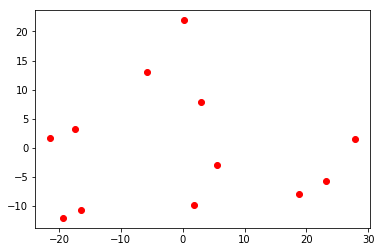

In [105]:
#dataset = np.transpose(dataset)
pca = PCA(n_components=2)
pca.fit(dataset_pca)
X_pca=pca.transform(dataset_pca)
plt.plot(X_pca[:,0],X_pca[:,1],'ro')
plt.show()

[1 1 0 0 0 0 1 0 1 0 1 1]


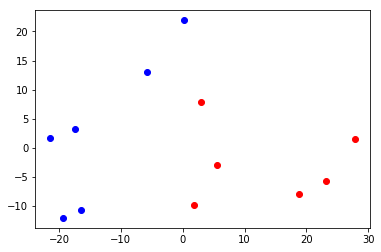

In [106]:
#explained = pca.explained_variance_ratio_
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_pca) ###number of cluster
labels = kmeans.labels_
centers = kmeans.cluster_centers_
print(labels)
plt.plot(X_pca[np.where(labels ==0),0],X_pca[np.where(labels ==0),1],'ro')
plt.plot(X_pca[np.where(labels ==1),0],X_pca[np.where(labels ==1),1],'bo')
plt.show()

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


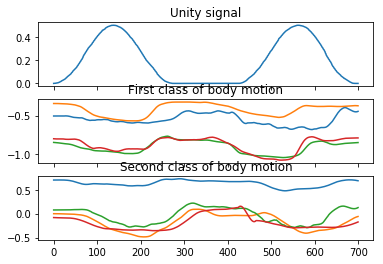

In [472]:
Y = orig
class1 = dataset_pca[np.where(labels ==0)]
class2 = dataset_pca[np.where(labels ==1)]
#VISUALIZE THE DIFFERENCE
fig, (ax_orig, ax_class1, ax_class2) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(Y)
ax_orig.set_title('Unity signal')
ax_class1.plot(class1[0])
ax_class1.plot(class1[1])
ax_class1.plot(class1[2])
ax_class1.plot(class1[3])
ax_class1.set_title('First class of body motion')
ax_class2.plot(class2[0])
ax_class2.plot(class2[1])
ax_class2.plot(class2[2])
ax_class2.plot(class2[3])
ax_class2.set_title('Second class of body motion')
fig.show()

# Multi input linear regression (both )

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.1410950283867609
0.32624824217684045
0.10887662598605363
0.28697731700957185
0.14595230904406653
0.17771500525081405
0.11069059835068341
0.4590056323410838
0.3141432213561068
0.5492607763915446
0.09954266667214044


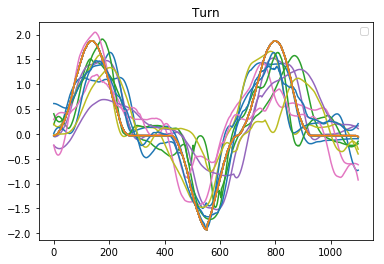

In [122]:
###TURN

from sklearn.linear_model import LinearRegression
marker_list=['pitch_1', 'yaw_5', 'pitch_5']

for i in range(11):
    data_reg=np.asarray(df_turn1['input1'])
    data_reg=data_reg[0:1100]
    for k in range(3):
        X=[]
        df_turn= eval('df_turn'+str(i+1)) 
        for column in df_turn:
            if column == marker_list[k]:
                X = np.asarray(df_turn[column])
                X = X[0:1100]
                X = signal.savgol_filter(X, 101, 3)
                data_reg = np.c_[data_reg, X]
    model = LinearRegression()
    X = data_reg[:,1:4]
    Y = data_reg[:,0]
    model.fit(X, Y)
    y_pred_filter =  model.predict(X)
    plt.title('Turn')
    plt.plot(y_pred_filter)
    plt.plot(Y)
    plt.legend()
    print(mean_squared_error(Y, y_pred_filter))

/Users/philippspiess/anaconda3/envs/HRI_mapping/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.30750078268563746
0.39034044560166486
0.4724897547021294
0.5849101827399689
0.8081641199716066
0.485013631940748
0.3364755135078519
0.26232678924361713
0.8345199014248973
0.4764544053082897
0.21555655618093095


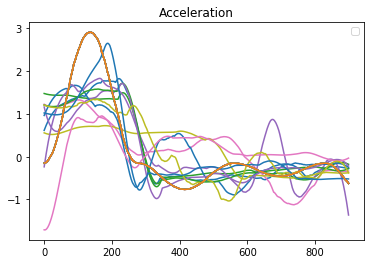

In [123]:
### SPEED

from sklearn.linear_model import LinearRegression
marker_list=['roll_8', 'roll_12', 'yaw_13']

data_reg=np.asarray(df_speed1['input2'])
data_reg=data_reg[0:900]
for i in range(11):
    data_reg=np.asarray(df_speed1['input2'])
    data_reg=data_reg[0:900]
    for k in range(3):
        X=[]
        df_speed= eval('df_speed'+str(i+1)) 
        for column in df_speed:
            if column == marker_list[k]:
                X = np.asarray(df_speed[column])
                X = X[0:900]
                X = signal.savgol_filter(X, 131, 3)
                data_reg = np.c_[data_reg, X]
    model = LinearRegression()
    X = data_reg[:,1:4]
    Y = data_reg[:,0]
    model.fit(X, Y)
    y_pred_filter =  model.predict(X)
    plt.title('Acceleration')
    plt.plot(y_pred_filter)
    plt.plot(Y)
    plt.legend()
    print(mean_squared_error(Y, y_pred_filter))